In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import umap

c:\Users\icaro\anaconda3\envs\esa-anomaly-challenge_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\icaro\anaconda3\envs\esa-anomaly-challenge_env\Lib\site-packages\umap\__init__.py:36: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
df_train = pd.read_parquet('train.parquet', engine='pyarrow')
df_test = pd.read_parquet('test.parquet', engine='pyarrow')

In [3]:
list(df_train.columns.values)

['id',
 'channel_1',
 'channel_10',
 'channel_11',
 'channel_12',
 'channel_13',
 'channel_14',
 'channel_15',
 'channel_16',
 'channel_17',
 'channel_18',
 'channel_19',
 'channel_2',
 'channel_20',
 'channel_21',
 'channel_22',
 'channel_23',
 'channel_24',
 'channel_25',
 'channel_26',
 'channel_27',
 'channel_28',
 'channel_29',
 'channel_3',
 'channel_30',
 'channel_31',
 'channel_32',
 'channel_33',
 'channel_34',
 'channel_35',
 'channel_36',
 'channel_37',
 'channel_38',
 'channel_39',
 'channel_4',
 'channel_40',
 'channel_41',
 'channel_42',
 'channel_43',
 'channel_44',
 'channel_45',
 'channel_46',
 'channel_47',
 'channel_48',
 'channel_49',
 'channel_5',
 'channel_50',
 'channel_51',
 'channel_52',
 'channel_53',
 'channel_54',
 'channel_55',
 'channel_56',
 'channel_57',
 'channel_58',
 'channel_59',
 'channel_6',
 'channel_60',
 'channel_61',
 'channel_62',
 'channel_63',
 'channel_64',
 'channel_65',
 'channel_66',
 'channel_67',
 'channel_68',
 'channel_69',
 'channel

In [4]:
# df_train.describe()

In [5]:
# From the original dataset description, The subset of 6 channels 41-46 is recommended as a
# good starting point for developing and testing algorithms before applying them to the full set.

df_train_4146 = df_train[['id', 'channel_41', 'channel_42', 'channel_43', 'channel_44', 'channel_45', 'channel_46', 'is_anomaly']].copy()
df_train_4146

,id,channel_41,channel_42,channel_43,channel_44,channel_45,channel_46,is_anomaly
0,0,0.812578,0.786344,0.771900,0.799178,0.816855,0.765296,0
1,1,0.812578,0.786344,0.771900,0.799178,0.816855,0.765296,0
2,2,0.821213,0.789557,0.770317,0.809411,0.816006,0.765296,0
3,3,0.819642,0.786344,0.770317,0.807050,0.816855,0.766985,0
4,4,0.821996,0.788753,0.770317,0.807837,0.818551,0.761073,0
...,...,...,...,...,...,...,...,...
14728316,14728316,0.806299,0.799999,0.767944,0.792093,0.821094,0.752628,0
14728317,14728317,0.806299,0.790360,0.765569,0.792881,0.821941,0.763607,0
14728318,14728318,0.806299,0.795180,0.765569,0.792881,0.822790,0.762762,0
14728319,14728319,0.806299,0.796786,0.767152,0.796816,0.820247,0.761073,0


In [35]:
num_anomaly = df_train_4146['is_anomaly'].value_counts().get(1, 0)
num_nominal = df_train_4146['is_anomaly'].value_counts().get(0, 0)

print('# of anomalies: ' + str(num_anomaly))
print('# of nominal: ' + str(num_nominal))

print('proportion of anomalies: ' + str((round(num_anomaly/len(df_train_4146), 4)*100)) + '%')

# of anomalies: 1544104
# of nominal: 13184217
proportion of anomalies: 10.48%


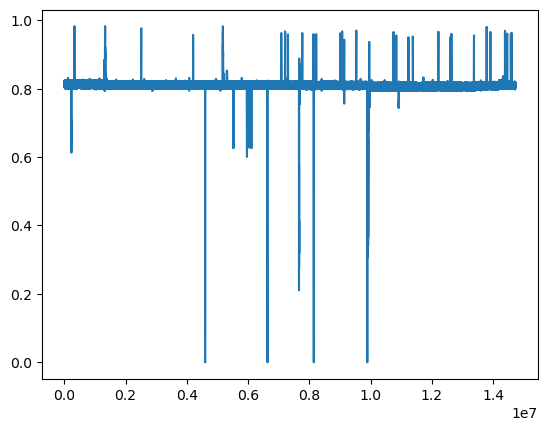

In [36]:
plt.plot(df_train_4146['id'], df_train_4146['channel_41'])

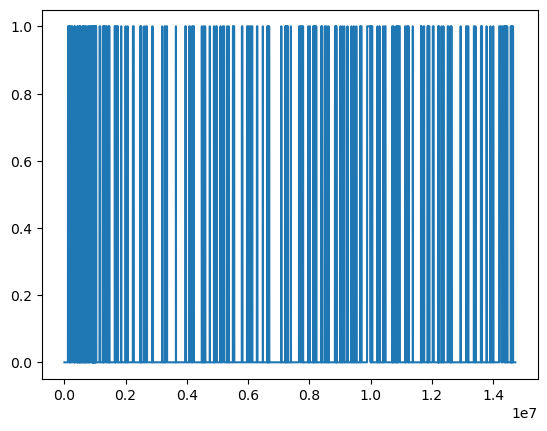

In [6]:
# Plot anomalies to visualize the data

X = np.array(df_train_4146['id'])
y = np.array(df_train_4146['is_anomaly'])

plt.plot(X, y)

In [7]:
# To make our analysis faster in the beginning, we will analyze the first 25% of the dataset
# later, we can apply the analysis in the whole dataset to check

analysis_percentage = 5
sample_df_train = df_train_4146.sample(n=50000, random_state=42).sort_values(by=["id"])
sample_df_train

,id,channel_41,channel_42,channel_43,channel_44,channel_45,channel_46,is_anomaly
230,230,0.814149,0.779114,0.781396,0.800752,0.808375,0.781340,0
842,842,0.808654,0.792770,0.781396,0.795242,0.816006,0.776273,0
1190,1190,0.818857,0.779114,0.767152,0.809411,0.811767,0.767829,0
1360,1360,0.811793,0.791966,0.770317,0.800752,0.821941,0.764451,0
1423,1423,0.811009,0.776705,0.780603,0.794455,0.811767,0.776273,0
...,...,...,...,...,...,...,...,...
14725606,14725606,0.817288,0.775902,0.767944,0.805476,0.808375,0.764451,0
14725612,14725612,0.815718,0.776705,0.771108,0.799966,0.804984,0.770361,0
14725739,14725739,0.807085,0.782327,0.777439,0.795242,0.811767,0.771206,0
14727097,14727097,0.809439,0.775099,0.773482,0.793667,0.802440,0.770361,0


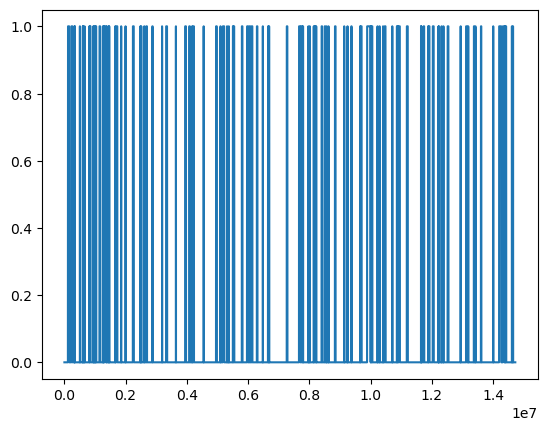

In [8]:
X = np.array(sample_df_train['id'])
y = np.array(sample_df_train['is_anomaly'])

plt.plot(X, y)

In [9]:
reducer = umap.UMAP()

In [10]:
df_train_data = sample_df_train[
    [
        "channel_41",
        "channel_42",
        "channel_43",
        "channel_44",
        "channel_45",
        "channel_46"
    ]
].values

scaled_df_train_data = StandardScaler().fit_transform(df_train_data)

In [11]:
scaled_df_train_data.shape

(50000, 6)

In [12]:
embedding = umap.UMAP().fit_transform(scaled_df_train_data)
embedding.shape

(50000, 2)

Text(0.5, 1.0, 'UMAP projection of the anomaly dataset')

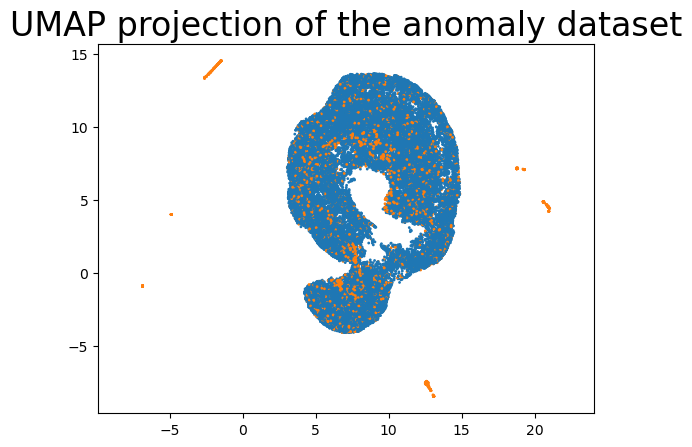

In [15]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in sample_df_train["is_anomaly"].map({0:0, 1:1})],
    s=1
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the anomaly dataset', fontsize=24)

In [25]:
df_train_4146['is_anomaly'].value_counts().get(0, 0)

13184217